<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/SqueezeNet_(torch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                                                ↑↑↑↑↑↑
                                        위의 Open in Colab 을 누르면 훨씬 가독성 있게 볼 수 있습니다.

---
# 1. 패키지 로드
---

In [ ]:
!pip install --upgrade albumentations

In [ ]:
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A
import torch.nn as nn
import math
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib inline 

#device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
# 2. 논문 분석

3가지 포인트
* 서론 및 동기 = 필요성

* 3가지 설계 전략

* Fire 모듈



그 외에 모델이 관련된 파라미터들을 어떻게 최적화하였는지, 만들어진 모델들에 대한 평가, CNN Microarchitecture & Macroarchitecture 에 대한 이야기가 나오지만, 구현에 중요한 부분만 요약하였음

---

## 1) 서론 및 동기 = 필요성


정확도를 높이는 관점을 넘어서 더 적은 매개변수의 가벼운 모델을 만드는데 초점을 두었음. 모델의 이름처럼 모델을 squeeze하는 법에 대한 이야기가 이 논문임. deep compression논문이랑 같이 읽으면서 생각해보면 좋을 듯

* 1. More efficient distributed training
    > 결국 CNN훈련도 서버와 통신이 필요. CNN확장성을 위해서는 통신 오버헤드를 줄여야함. 
    
    > 즉 모델을 줄여서 less communication을 하면 빠른 학습을 가능하게함.

* 2. Less overhead when exporting new models to clients
    > 새로운 모델을 고객한테 전할 때도 훨씬 빠르다. 특히 반자율주행에 대한 이야기를 하면서 Alex넷 예시를 이야기함. 가령 알렉스 넷은 서버와 자동차 사이 240MB나 요구함. 

    > 즉, 모델을 줄여서 less communication을 하면 더 자주 업데이트 하고 유연한 운영을 가능하게 해줌.
    

* 3. Feasible FPGA and embedded deployment.
    > FPGA칩은 보통 10MB의 메모리를 가지는데 이런 작은 메모리에도 넣을 수 있다. 그 외의 메모리가 작은 장치에 직접 넣을 수 있다. 이런 이야기. 칩 관련 용어는 모르는 부분이지만 의미는 이해 가능.

## 2) 3가지 설계 전략



1.   Replace 3x3 filters with 1x1 filters
> x9 만큼이나 적은 파라미터


2.   Decrease the number of input channels to 3x3 filters
> 3x3 필터를 줄이는 것 뿐만 아니라(1번 전략) 3x3에 들어가는 채널 수 자체도 줄여야함.  >> squeeze layer를 통해 줄이겠음.

3.   Downsample late in the network so that convolution layers have large activation
> (저자들이) 직관적으로 생각해보면, 다운샘플링을 뒤로 미뤄서 큰 activation map이 뒤에까지 오면 이게 더 높은 정확도를 제공할 것.

            다운샘플링 자체가 정보를 상실 시키니까. 
            내가 생각해도 그렇다.






## 3) Fire 모듈


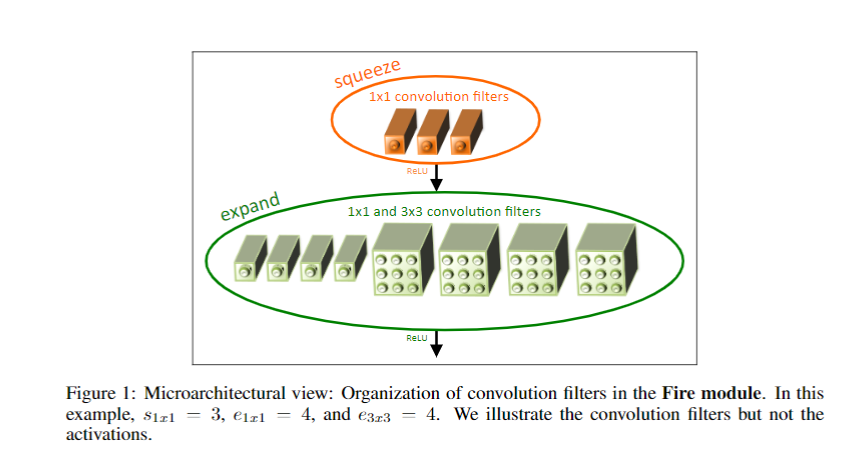

* 위쪽의 스퀴즈레이어와, 아래쪽의 확장레이어로 구성되어있음.
(sqeeze and expand)

* s(1x), e(1x), e(3x) 파라미터로 구성되어있음. 
    > 각각이 해당하는 필터의 수를 의미함. 

    > 중요한 건 s(1x)를 e(1x) + e(3x)보다 작게 설정해주는 것. 이렇게 해서 전략 2번(3x3에 들어가는 채널 수 자체를 줄인다)을 지킴.


---


# 3. 구현

squeezenet은 논문에서 제시한 3가지 버전이 있다.

1. Vanilla SqueezeNet
2. SqueezeNet with simple bypass connections between some Fire modules.
3. SqueezeNet with complex bypass connections between the remaining Fire modules. 

간단하게 이해하면, 처음 것은 날 것 그대로, 두번째 것은 resnet같은 shortcut 추가. 마지막은, 채널이 변할 때도 shortcut을 넣기 위해 conv1x1을 통한 복잡한 shortcut 구성이라고 보면 된다.

    결론적으로 측정했을 때 두번째 모델이 가장 좋았다고 하니까
    두번째 모델을 구현하기로 결정

그 외에 디테일한 내용들(학습율, dropout, activation) 등등은 데이터 자체가 다르니까 편의에 따라 바꿔서 구현.


---







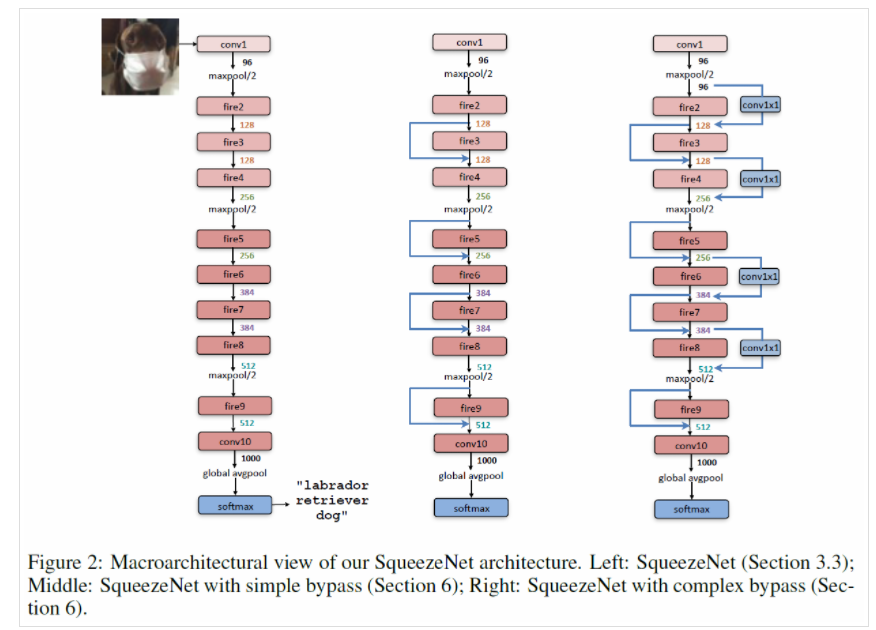

## 기본구조 구현

In [ ]:
def conv_block(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 'valid' , **kwargs) :
    """ 
    conv들이 기본적으로 ReLU를 가지고 있고,
    성능향상을 위해서 BN층도 추가하여 block으로 만든다.
    BN을 사용하므로 bias는 False로 둔다.
    """
    output = nn.Sequential(
       nn.Conv2d(in_channels, out_channels, kernel_size ,stride, padding ,bias =False, **kwargs),
       nn.BatchNorm2d(out_channels),
       nn.ReLU()
    )
    return output

## Fire 블럭 구현

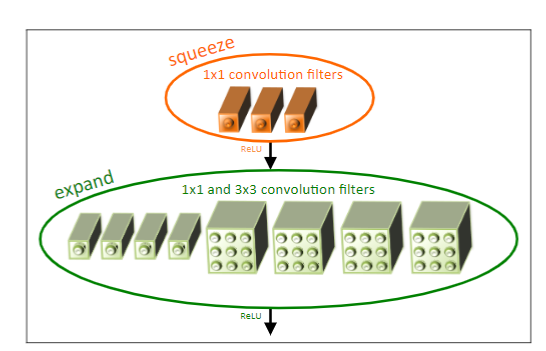

In [ ]:
class FireModule(nn.Module):
    '''
    논문에서 제시한 param 그대로 사용

    input_channels : -
    s1 : squeeze layer param
    e1 : expand layer 1x1 param 
    e3 : expand layer 3x3 param 
    '''

    def __init__(self, input_channels, s1, e1, e3):
        super(FireModule, self).__init__()        
        
        self.squeeze1 = conv_block(input_channels, s1, kernel_size = 1)
        self.expand1 = conv_block(s1, e1, kernel_size  = 1 )
        self.expand2 = conv_block(s1, e3, kernel_size  = 3 , padding = 'same')



    def forward(self, input_tensor):
        x = self.squeeze1(input_tensor)
        output = torch.cat([
             self.expand1(x),
             self.expand2(x)
             ], 1 )

        return output




## SqueezeNet 구현

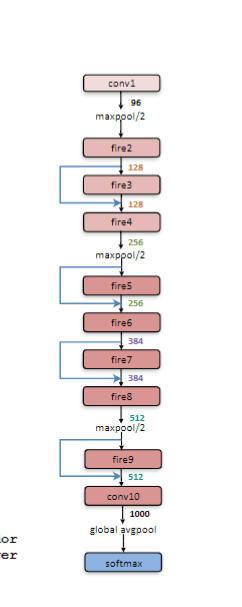

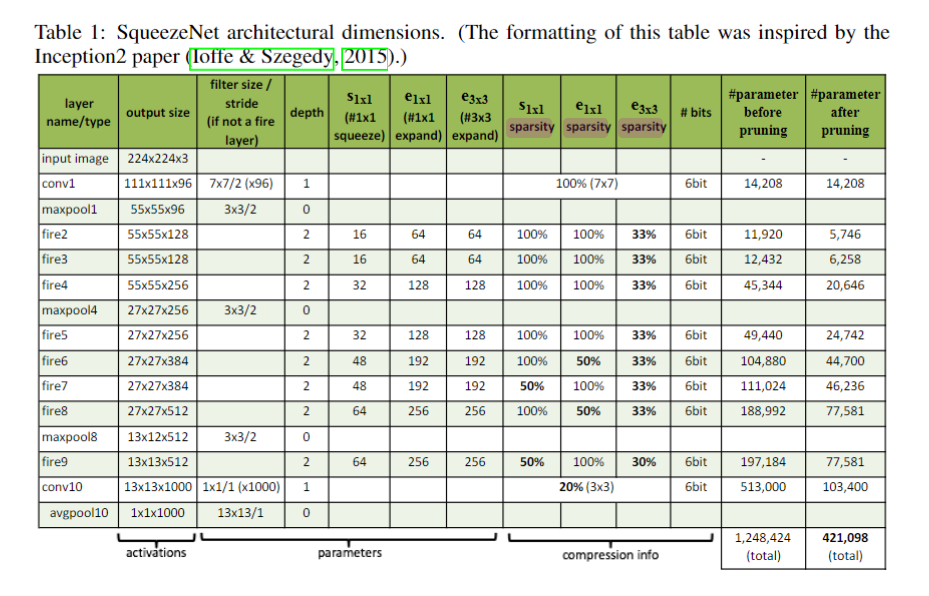



In [ ]:
class SqueezeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(SqueezeNet, self).__init__()    

        self.bottom = conv_block(3,96,kernel_size = 7, stride = 2, padding = 2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        
        self.fire1 = FireModule(96, 16, 64, 64)
        self.fire2 = FireModule(128, 16, 64, 64)
        self.fire3 = FireModule(128, 32, 128, 128)

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire4 = FireModule(256, 32, 128, 128)
        self.fire5 = FireModule(256, 48, 192, 192)
        self.fire6 = FireModule(384, 48, 192, 192)
        self.fire7 = FireModule(384, 64, 256, 256)

        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire8 = FireModule(512, 64, 256, 256)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(512, num_classes, kernel_size=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1)),
            nn.Flatten()
        )
        self._initialize_weights()




    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


    def forward(self, input_tensor):
        x = self.bottom(input_tensor)        
        x = self.pool1(x)

        x = self.fire1(x)
        identity = x
        x = self.fire2(x)
        x = self.fire3(x+identity)
        x = self.pool2(x)

        identity = x
        x = self.fire4(x)
        x = self.fire5(x+identity)
        identity = x
        x = self.fire6(x)
        x = self.fire7(x+identity)
        x = self.pool3(x)

        identity = x
        x = self.fire8(x)
        x = self.classifier(x+identity)
        
        return x 


In [ ]:
# 모델 확인
model = SqueezeNet().to(device)
summary(model, (3,224,224))
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 111, 111]          14,112
       BatchNorm2d-2         [-1, 96, 111, 111]             192
              ReLU-3         [-1, 96, 111, 111]               0
         MaxPool2d-4           [-1, 96, 55, 55]               0
            Conv2d-5           [-1, 16, 55, 55]           1,536
       BatchNorm2d-6           [-1, 16, 55, 55]              32
              ReLU-7           [-1, 16, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           1,024
       BatchNorm2d-9           [-1, 64, 55, 55]             128
             ReLU-10           [-1, 64, 55, 55]               0
           Conv2d-11           [-1, 64, 55, 55]           9,216
      BatchNorm2d-12           [-1, 64, 55, 55]             128
             ReLU-13           [-1, 64, 55, 55]               0
       FireModule-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


---
# 4. 데이터 전처리
---

## 데이터 로드
 * 이미지 채크
 * STL10 (3,96,96)의 토치형식


In [ ]:
trainset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform= transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = trainset.classes

In [ ]:
batch_size = 7
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = trainset.classes
# 클래스 정보 가져오기

In [ ]:
# trainloader.

In [ ]:
# 이미지를 보여주기 위한 함수
def show_images(images, labels, ncols=4):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.transpose(images[i], (1, 2, 0)))
        # 차원이 바뀌므로 바꿔줘야함
        axs[i].set_title(classes[labels[i]])

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
labels.shape

torch.Size([7])

(3, 96, 96)
torch.Size([3, 96, 96])


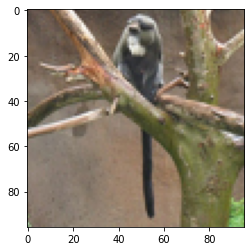

In [ ]:
# 잘 들어왔나 확인
# plt.imshow(trainset.data[1])
# STL은 애초에 데이터셋 자체가 텐서형식임((3, 96, 96))
# Totensor(데이터 로더를 통해)하면 알아서 차원까지 transpose해줌.
# cifar 경우 32 32 3 임. plt가 32,32,3 으로 받기 때문에 plt 통해 출력하려면 transpose가 필요
plt.imshow(np.transpose(trainset.data[1], (1, 2, 0)))

print(trainset.data[1].shape)
print(images[1].shape)

In [ ]:
print(trainset.data[1][1,:3,0:3])
print(images[1][1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1]/255)[1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1])[1,:3,0:3])
# trainloader의 trasform을 거치는 것 만으로 0~1로 정규화된다.
# 아래 transform에서 평균과 표준편차로 나누는 것은 정확히는 표준화이다.
# totensor를 거치면 자동으로 0~1로 정규화 된다. 그리고 totensor 안에 transpose도 들어있는듯
# totensor안에 정규화가 들어있는데, 값이 이미 정규화되어있으면 하지 않음. 3,4번 라인비교


[[73 81 89]
 [71 79 86]
 [64 77 80]]
tensor([[0.2863, 0.3176, 0.3490],
        [0.2784, 0.3098, 0.3373],
        [0.2510, 0.3020, 0.3137]])
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]], dtype=torch.float64)
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]])


In [ ]:
# 아래처럼, loader안에 transpose 후 totensor하면 원하던 차원순서 312가 나옴
testnp = np.zeros((3,1,2))
print(testnp.shape)
print(transforms.ToTensor()(testnp).shape)
print(np.transpose(testnp, (1, 2, 0)).shape)
print(transforms.ToTensor()(np.transpose(testnp, (1, 2, 0))).shape)

(3, 1, 2)
torch.Size([2, 3, 1])
(1, 2, 3)
torch.Size([3, 1, 2])


In [ ]:
print(trainset.data[1].shape)
print(images[1].shape)
print(transforms.ToTensor()(trainset.data[1]).shape)

# totansor뿐만아니라 loader까지 거쳐야 원하는 차원으로 나오는듯
# 아마 로더에 차원 변경이 구현되어있는듯
# 아래 커스텀 모델에 이것도 구현해야함.

(3, 96, 96)
torch.Size([3, 96, 96])
torch.Size([96, 3, 96])


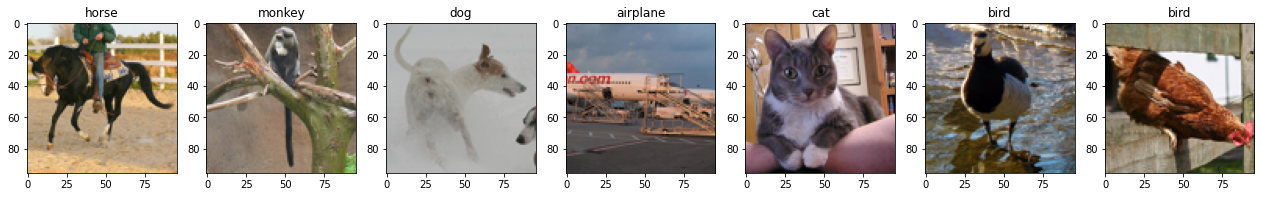

In [ ]:
# 이미지 보여주기
show_images(images,labels,7)

In [ ]:
images[1][1,1,1]

tensor(0.3098)

In [ ]:
aa = np.transpose(trainset.data[1], (1, 2, 0))
print(transforms.ToTensor()(aa).shape)

torch.Size([3, 96, 96])


## 커스텀 데이터셋 구현
* albumentations을 사용하기 위해서 커스텀 데이터 셋을 구현한다.
* 파이토치 텐서플로우 전부 이미지를 배치단위로 cpu,gpu 옮기는 과정에 병목이 있다고 알고있음. 즉, tf나 torch나 데이터 파이프 라인을 그대로 쓰는 것 보다 albumentations을 이용하는 것이 훨씬빠름.




In [ ]:
# 커스텀 데이터(albumenatation 적용)
class ForAlbuSet(Dataset):
    def __init__(self, dataset, transform = None ,data_type = "train" ):
        self.dataset = dataset
        self.transform = transform
        self.data_type = data_type


    def __len__(self):
        return self.dataset.data.shape[0]

    def __getitem__(self, index):
        image = self.dataset.data[index]
        image = np.transpose(image, (1, 2, 0))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 위옵션은 cv2.imread에서 필요함
        label = self.dataset.labels[index]
        # CIFAR에서는 데이터셋 안에 label이 아니라 target으로 적혀있음.
        # CIFAR는 int반환이지만 얘는 numpy.unit8
        # label과 image를 output 결과와 통일 시켜야함(int,long, float, double 등등)
        # 형변환은 train에서 구현 : 데이터셋과 상관없이 항상 필요한 작업

        
        if self.data_type == "train" : 
            # random_n = np.random.randint(148,256)
            # image = cv2.resize(image, (random_n,random_n))
            # resize로 멀티스케일을 작게나마 구현 해보았음
            # 다만 너무 계산시간이 커진다.


            if self.transform is not None:
                image = self.transform(image=image)["image"]        
        else :

            if self.transform is not None:
                image = self.transform(image=image)["image"]


        return image, label
    

## 증강(transform)

* 토치의 transform 사용시에는 to 텐서 다음에 노말 하기. totensor를 해야 값들이 0\~1사이로감. 그래야 imagenet 평균과 표준편차를 사용가능(0\~255가 아니라 0~1이니까)
    > albumentation은 구현코드를 확인해보면, normalize안에 자동으로 255로 나눠서 구현되어있음.


* torchvision.transforms.(채널, 세로, 가로) 과 달리 Albu.transforms 는 array 기준으로 작업함(세로,가로,채널)
* cv2는 (가로,세로,채널)

* (주의) totensor없으면 loader가 작동 안 함.(차원 순서 바뀌기 때문)

* 실험과정에서 성능이 좋지않아서 논문과 다른 장치들을 넣었음.

In [ ]:
augmentor_tr = A.Compose([        
    # A.Resize(232,232),
    A.Resize(224,224),                
    # A.FancyPCA(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

augmentor_test = A.Compose([
    A.Resize(224,224),                            
    A.Normalize(),
    ToTensorV2()
])

## 분할

* random_split이 Torch.utils.data.dataset.random_split에도 있는데, 이건 제대로 작동 안 하니까 조심, random_split은 분할을 하지만 원본을 그대로 두고 랜덤인덱스로 불러오는 원리.아마 메모리 관리를 위해 이렇게 구현한듯

* STL10 데이터는 테스트가 8000개고 트레인이 5000개 이다. 테스트가 트레인보다 많으므로, test데이터로 train에쓰고 train 데이터로 테스트에 쓰자. 트레인 데이터가 더 많아야 한다. 
    > 위의 로딩식 수정했음. 
    
* 또한 분할을 이용해서 5000개를 3000/2000으로 나누어 validation과 test를 하자.

In [ ]:
val_ratio = 0.6
val_size = round(len(testset)*val_ratio)
test_size = len(testset) - val_size
                    
val_set, test_set= random_split(
    testset,
    [val_size,test_size],
    generator=torch.Generator().manual_seed(20)
    )

In [ ]:
# 분할 채크
len(val_set)

3000

In [ ]:
ab_train_set = ForAlbuSet(trainset, transform=augmentor_tr)
ab_val_set = ForAlbuSet(val_set.dataset, transform=augmentor_test, data_type= 'val')
ab_test_set = ForAlbuSet(test_set.dataset, transform=augmentor_test, data_type= 'test')


In [ ]:
batch_size = 64
train_loader = DataLoader(ab_train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = DataLoader(ab_val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = DataLoader(ab_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)




---
# 5. 학습 및 평가
---

**구현목표**
* 정확도 metric 구현 
* 로스, 정확도 동시에 출력
* 콜백(reducelr, earlystop)
* 작업진행도 모니터링 출력
* 테스트 loss 변화 그래프로 출력
* train, vaildate, fit 구현



## early stopping class 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')

        self.val_loss_min = val_loss

## train, validate, fit, test 함수 정의

In [ ]:
def train(model,train_loader, criterion, optimizer, epoch):
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for images, target in stream:
        images = images.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()

        output = model(images)
        sum_loss = criterion(output, target)
        loss = sum_loss/len(target)
        # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
        # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.



        loss.backward()
        optimizer.step()

        # 로스합
        train_loss +=sum_loss.item()

        # 정확도 계산
        pred = output.max(dim = 1,keepdim = True)[1]
        correct += (target.view(-1, 1) == pred).sum().item()


        stream.set_description(
            f"Epoch: {epoch}. Train."
        )
        

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [ ]:
def validate(model, val_loader, criterion, epoch):
    model.eval()
    stream = tqdm(val_loader)
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images, target in stream:
            images = images.to(device).float()
            target = target.to(device).long()

            output = model(images)
            sum_loss = criterion(output, target)
            loss = sum_loss/len(target)
            # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
            # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.

            # 로스합
            val_loss +=sum_loss.item()

            # 정확도 계산
            pred = output.max(dim = 1,keepdim = True)[1]
            correct += (target.view(-1, 1) == pred).sum().item()




            stream.set_description(
                f"Epoch: {epoch}. Validate."
            )
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, val_accuracy

In [ ]:
def fit(model,train_loader,val_loader,criterion,optimizer,epoch, early_stopping=None, scheduler=None):
 
    # epoch당 average loss를 track하기 위한 list
    avg_train_losses = []
    avg_val_losses = []
    avg_train_accuracy = []
    avg_val_accuracy = []

    for i in range(1, epoch + 1):
        train_loss ,train_accuracy =train( model,train_loader, criterion, optimizer, i)
        print(f"[{i}] Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        val_loss ,val_accuracy = validate( model,val_loader, criterion, i)
        if i == epoch :
            sleep(0.1)
            # 마지막 출력에서 tqdm이 업데이트 되기전에 아래 출력값이 나오지 않도록.
            # 다른 줄에 아래값이 나올 수 있게 해줌
        print(f"[{i}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


        
        if scheduler is not None :
            # scheduler.step()
            scheduler.step(val_loss) 
            # 아래는 reducelronplateau 전용
            

        avg_train_losses.append(train_loss)
        avg_val_losses.append(val_loss)
        avg_train_accuracy.append(train_accuracy)
        avg_val_accuracy.append(val_accuracy)

        
        if early_stopping is not None :
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print()
                print("Early stopping")
                sleep(0.1)
                break

        print()

                         
    return  model, avg_train_losses, avg_val_losses,  avg_train_accuracy , avg_val_accuracy


In [ ]:
def test(model, test_loader, criterion):
    test_loss ,test_accuracy = validate( model,test_loader, criterion, 1)
    sleep(0.1)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    
    return (test_loss ,test_accuracy)

## 학습

In [ ]:
model = SqueezeNet(10).to(device)

In [ ]:
# loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(reduction='sum')


# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 스케쥴러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# early_stopping
early_stopping = EarlyStopping(patience = 15, verbose = True)

In [ ]:
model, train_loss, val_loss ,train_accuracy ,val_accuracy= fit(model,train_loader,val_loader,criterion,optimizer,100,early_stopping,scheduler)

Epoch: 1. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.38it/s]


[1] Train Loss: 3.0473, Accuracy: 20.79%


Epoch: 1. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.15it/s]


[1] Validation Loss: 1.9628, Accuracy: 27.64%
Validation loss decreased (inf --> 1.962787).



Epoch: 2. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[2] Train Loss: 2.0755, Accuracy: 26.68%


Epoch: 2. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


[2] Validation Loss: 1.7840, Accuracy: 32.14%
Validation loss decreased (1.962787 --> 1.784007).



Epoch: 3. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[3] Train Loss: 1.9150, Accuracy: 29.64%


Epoch: 3. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.18it/s]


[3] Validation Loss: 1.7422, Accuracy: 33.46%
Validation loss decreased (1.784007 --> 1.742213).



Epoch: 4. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.33it/s]


[4] Train Loss: 1.8398, Accuracy: 31.82%


Epoch: 4. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.23it/s]


[4] Validation Loss: 1.6950, Accuracy: 36.04%
Validation loss decreased (1.742213 --> 1.695036).



Epoch: 5. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.33it/s]


[5] Train Loss: 1.8004, Accuracy: 32.70%


Epoch: 5. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.01it/s]


[5] Validation Loss: 1.6873, Accuracy: 36.74%
Validation loss decreased (1.695036 --> 1.687302).



Epoch: 6. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[6] Train Loss: 1.7719, Accuracy: 33.79%


Epoch: 6. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


[6] Validation Loss: 1.6404, Accuracy: 40.00%
Validation loss decreased (1.687302 --> 1.640378).



Epoch: 7. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.33it/s]


[7] Train Loss: 1.7128, Accuracy: 35.77%


Epoch: 7. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.08it/s]


[7] Validation Loss: 1.6489, Accuracy: 38.52%
EarlyStopping counter: 1 out of 15



Epoch: 8. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[8] Train Loss: 1.6951, Accuracy: 36.16%


Epoch: 8. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.14it/s]


[8] Validation Loss: 1.6131, Accuracy: 40.38%
Validation loss decreased (1.640378 --> 1.613074).



Epoch: 9. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.34it/s]


[9] Train Loss: 1.6716, Accuracy: 37.45%


Epoch: 9. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.99it/s]


[9] Validation Loss: 1.5805, Accuracy: 40.68%
Validation loss decreased (1.613074 --> 1.580547).



Epoch: 10. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.33it/s]


[10] Train Loss: 1.6723, Accuracy: 37.50%


Epoch: 10. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.04it/s]


[10] Validation Loss: 1.5432, Accuracy: 43.06%
Validation loss decreased (1.580547 --> 1.543182).



Epoch: 11. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[11] Train Loss: 1.6199, Accuracy: 39.19%


Epoch: 11. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.00it/s]


[11] Validation Loss: 1.4994, Accuracy: 44.56%
Validation loss decreased (1.543182 --> 1.499407).



Epoch: 12. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[12] Train Loss: 1.5845, Accuracy: 40.83%


Epoch: 12. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.10it/s]


[12] Validation Loss: 1.5610, Accuracy: 42.34%
EarlyStopping counter: 1 out of 15



Epoch: 13. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[13] Train Loss: 1.5732, Accuracy: 41.44%


Epoch: 13. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.14it/s]


[13] Validation Loss: 1.5198, Accuracy: 43.78%
EarlyStopping counter: 2 out of 15



Epoch: 14. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[14] Train Loss: 1.5712, Accuracy: 41.89%


Epoch: 14. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.10it/s]


[14] Validation Loss: 1.4975, Accuracy: 44.94%
Validation loss decreased (1.499407 --> 1.497521).



Epoch: 15. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[15] Train Loss: 1.5385, Accuracy: 42.84%


Epoch: 15. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.08it/s]


[15] Validation Loss: 1.4635, Accuracy: 46.42%
Validation loss decreased (1.497521 --> 1.463538).



Epoch: 16. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[16] Train Loss: 1.5131, Accuracy: 43.98%


Epoch: 16. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.12it/s]


[16] Validation Loss: 1.4552, Accuracy: 45.38%
Validation loss decreased (1.463538 --> 1.455172).



Epoch: 17. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[17] Train Loss: 1.5158, Accuracy: 44.61%


Epoch: 17. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.19it/s]


[17] Validation Loss: 1.4471, Accuracy: 46.44%
Validation loss decreased (1.455172 --> 1.447063).



Epoch: 18. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.33it/s]


[18] Train Loss: 1.4882, Accuracy: 45.21%


Epoch: 18. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.10it/s]


[18] Validation Loss: 1.4341, Accuracy: 47.84%
Validation loss decreased (1.447063 --> 1.434100).



Epoch: 19. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


[19] Train Loss: 1.4805, Accuracy: 44.49%


Epoch: 19. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.04it/s]


[19] Validation Loss: 1.4077, Accuracy: 49.08%
Validation loss decreased (1.434100 --> 1.407687).



Epoch: 20. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.33it/s]


[20] Train Loss: 1.4549, Accuracy: 46.71%


Epoch: 20. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.08it/s]


[20] Validation Loss: 1.4101, Accuracy: 49.76%
EarlyStopping counter: 1 out of 15



Epoch: 21. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[21] Train Loss: 1.4509, Accuracy: 46.09%


Epoch: 21. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.11it/s]


[21] Validation Loss: 1.3944, Accuracy: 49.40%
Validation loss decreased (1.407687 --> 1.394407).



Epoch: 22. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[22] Train Loss: 1.4424, Accuracy: 46.58%


Epoch: 22. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.00it/s]


[22] Validation Loss: 1.3848, Accuracy: 49.36%
Validation loss decreased (1.394407 --> 1.384784).



Epoch: 23. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


[23] Train Loss: 1.4355, Accuracy: 46.69%


Epoch: 23. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


[23] Validation Loss: 1.3205, Accuracy: 52.12%
Validation loss decreased (1.384784 --> 1.320477).



Epoch: 24. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


[24] Train Loss: 1.4313, Accuracy: 47.04%


Epoch: 24. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.00it/s]


[24] Validation Loss: 1.3461, Accuracy: 51.26%
EarlyStopping counter: 1 out of 15



Epoch: 25. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[25] Train Loss: 1.4179, Accuracy: 48.05%


Epoch: 25. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.11it/s]


[25] Validation Loss: 1.3470, Accuracy: 51.36%
EarlyStopping counter: 2 out of 15



Epoch: 26. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


[26] Train Loss: 1.4005, Accuracy: 48.14%


Epoch: 26. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.98it/s]


[26] Validation Loss: 1.3544, Accuracy: 51.22%
EarlyStopping counter: 3 out of 15



Epoch: 27. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


[27] Train Loss: 1.3838, Accuracy: 49.46%


Epoch: 27. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.09it/s]


[27] Validation Loss: 1.2837, Accuracy: 53.32%
Validation loss decreased (1.320477 --> 1.283747).



Epoch: 28. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[28] Train Loss: 1.3654, Accuracy: 50.33%


Epoch: 28. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.17it/s]


[28] Validation Loss: 1.2767, Accuracy: 53.76%
Validation loss decreased (1.283747 --> 1.276657).



Epoch: 29. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


[29] Train Loss: 1.3653, Accuracy: 49.90%


Epoch: 29. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.03it/s]


[29] Validation Loss: 1.3306, Accuracy: 51.80%
EarlyStopping counter: 1 out of 15



Epoch: 30. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


[30] Train Loss: 1.3527, Accuracy: 50.05%


Epoch: 30. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.02it/s]


[30] Validation Loss: 1.3128, Accuracy: 52.50%
EarlyStopping counter: 2 out of 15



Epoch: 31. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[31] Train Loss: 1.3432, Accuracy: 50.49%


Epoch: 31. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.09it/s]


[31] Validation Loss: 1.2882, Accuracy: 53.56%
EarlyStopping counter: 3 out of 15



Epoch: 32. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[32] Train Loss: 1.3369, Accuracy: 50.42%


Epoch: 32. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.10it/s]


[32] Validation Loss: 1.2413, Accuracy: 55.52%
Validation loss decreased (1.276657 --> 1.241331).



Epoch: 33. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


[33] Train Loss: 1.3194, Accuracy: 51.46%


Epoch: 33. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.07it/s]


[33] Validation Loss: 1.2610, Accuracy: 54.48%
EarlyStopping counter: 1 out of 15



Epoch: 34. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


[34] Train Loss: 1.3041, Accuracy: 51.99%


Epoch: 34. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.97it/s]


[34] Validation Loss: 1.2127, Accuracy: 57.22%
Validation loss decreased (1.241331 --> 1.212723).



Epoch: 35. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


[35] Train Loss: 1.3116, Accuracy: 51.89%


Epoch: 35. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.09it/s]


[35] Validation Loss: 1.2160, Accuracy: 56.56%
EarlyStopping counter: 1 out of 15



Epoch: 36. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[36] Train Loss: 1.2892, Accuracy: 53.42%


Epoch: 36. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.12it/s]


[36] Validation Loss: 1.2481, Accuracy: 54.94%
EarlyStopping counter: 2 out of 15



Epoch: 37. Train.: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


[37] Train Loss: 1.2836, Accuracy: 52.20%


Epoch: 37. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


[37] Validation Loss: 1.2532, Accuracy: 56.34%
EarlyStopping counter: 3 out of 15



Epoch: 38. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[38] Train Loss: 1.2801, Accuracy: 53.09%


Epoch: 38. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.07it/s]


[38] Validation Loss: 1.2214, Accuracy: 55.36%
EarlyStopping counter: 4 out of 15



Epoch: 39. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


[39] Train Loss: 1.2777, Accuracy: 53.49%


Epoch: 39. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.01it/s]


[39] Validation Loss: 1.1763, Accuracy: 57.30%
Validation loss decreased (1.212723 --> 1.176294).



Epoch: 40. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[40] Train Loss: 1.2673, Accuracy: 53.79%


Epoch: 40. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.10it/s]


[40] Validation Loss: 1.2169, Accuracy: 57.08%
EarlyStopping counter: 1 out of 15



Epoch: 41. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


[41] Train Loss: 1.2569, Accuracy: 54.08%


Epoch: 41. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.02it/s]


[41] Validation Loss: 1.1907, Accuracy: 58.24%
EarlyStopping counter: 2 out of 15



Epoch: 42. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[42] Train Loss: 1.2601, Accuracy: 53.81%


Epoch: 42. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


[42] Validation Loss: 1.1996, Accuracy: 56.66%
EarlyStopping counter: 3 out of 15



Epoch: 43. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


[43] Train Loss: 1.2262, Accuracy: 55.02%


Epoch: 43. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.99it/s]


[43] Validation Loss: 1.2278, Accuracy: 56.88%
EarlyStopping counter: 4 out of 15



Epoch: 44. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[44] Train Loss: 1.2513, Accuracy: 54.54%


Epoch: 44. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.91it/s]


[44] Validation Loss: 1.1526, Accuracy: 58.82%
Validation loss decreased (1.176294 --> 1.152641).



Epoch: 45. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[45] Train Loss: 1.2221, Accuracy: 55.09%


Epoch: 45. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.97it/s]


[45] Validation Loss: 1.2014, Accuracy: 57.50%
EarlyStopping counter: 1 out of 15



Epoch: 46. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[46] Train Loss: 1.2019, Accuracy: 55.96%


Epoch: 46. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.99it/s]


[46] Validation Loss: 1.1707, Accuracy: 58.16%
EarlyStopping counter: 2 out of 15



Epoch: 47. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[47] Train Loss: 1.2132, Accuracy: 55.95%


Epoch: 47. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.90it/s]


[47] Validation Loss: 1.1661, Accuracy: 58.56%
EarlyStopping counter: 3 out of 15



Epoch: 48. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[48] Train Loss: 1.2037, Accuracy: 56.62%


Epoch: 48. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.05it/s]


[48] Validation Loss: 1.2037, Accuracy: 57.32%
EarlyStopping counter: 4 out of 15



Epoch: 49. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


[49] Train Loss: 1.2031, Accuracy: 55.94%


Epoch: 49. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.97it/s]


[49] Validation Loss: 1.1232, Accuracy: 59.94%
Validation loss decreased (1.152641 --> 1.123228).



Epoch: 50. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[50] Train Loss: 1.1841, Accuracy: 57.12%


Epoch: 50. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.01it/s]


[50] Validation Loss: 1.1517, Accuracy: 59.14%
EarlyStopping counter: 1 out of 15



Epoch: 51. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[51] Train Loss: 1.1868, Accuracy: 57.27%


Epoch: 51. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.02it/s]


[51] Validation Loss: 1.1330, Accuracy: 59.46%
EarlyStopping counter: 2 out of 15



Epoch: 52. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[52] Train Loss: 1.1799, Accuracy: 57.23%


Epoch: 52. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.02it/s]


[52] Validation Loss: 1.1450, Accuracy: 59.02%
EarlyStopping counter: 3 out of 15



Epoch: 53. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[53] Train Loss: 1.1752, Accuracy: 57.49%


Epoch: 53. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.83it/s]


[53] Validation Loss: 1.2223, Accuracy: 57.58%
EarlyStopping counter: 4 out of 15



Epoch: 54. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


[54] Train Loss: 1.1813, Accuracy: 56.71%


Epoch: 54. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.91it/s]


[54] Validation Loss: 1.1314, Accuracy: 59.76%
EarlyStopping counter: 5 out of 15



Epoch: 55. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[55] Train Loss: 1.1582, Accuracy: 57.95%


Epoch: 55. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.00it/s]


[55] Validation Loss: 1.1536, Accuracy: 59.86%
EarlyStopping counter: 6 out of 15



Epoch: 56. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[56] Train Loss: 1.1460, Accuracy: 58.69%


Epoch: 56. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.87it/s]


[56] Validation Loss: 1.1407, Accuracy: 60.10%
EarlyStopping counter: 7 out of 15



Epoch: 57. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[57] Train Loss: 1.1576, Accuracy: 58.39%


Epoch: 57. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.84it/s]


[57] Validation Loss: 1.1300, Accuracy: 60.64%
EarlyStopping counter: 8 out of 15



Epoch: 58. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[58] Train Loss: 1.1320, Accuracy: 58.98%


Epoch: 58. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


[58] Validation Loss: 1.1107, Accuracy: 60.30%
Validation loss decreased (1.123228 --> 1.110679).



Epoch: 59. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[59] Train Loss: 1.1388, Accuracy: 58.86%


Epoch: 59. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.09it/s]


[59] Validation Loss: 1.2142, Accuracy: 57.88%
EarlyStopping counter: 1 out of 15



Epoch: 60. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[60] Train Loss: 1.1228, Accuracy: 59.74%


Epoch: 60. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.90it/s]


[60] Validation Loss: 1.0936, Accuracy: 61.80%
Validation loss decreased (1.110679 --> 1.093635).



Epoch: 61. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[61] Train Loss: 1.1268, Accuracy: 59.44%


Epoch: 61. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.12it/s]


[61] Validation Loss: 1.1148, Accuracy: 59.70%
EarlyStopping counter: 1 out of 15



Epoch: 62. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[62] Train Loss: 1.1331, Accuracy: 59.02%


Epoch: 62. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.03it/s]


[62] Validation Loss: 1.0966, Accuracy: 61.00%
EarlyStopping counter: 2 out of 15



Epoch: 63. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[63] Train Loss: 1.1263, Accuracy: 58.84%


Epoch: 63. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


[63] Validation Loss: 1.1094, Accuracy: 60.56%
EarlyStopping counter: 3 out of 15



Epoch: 64. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


[64] Train Loss: 1.1097, Accuracy: 60.04%


Epoch: 64. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.87it/s]


[64] Validation Loss: 1.0954, Accuracy: 61.64%
EarlyStopping counter: 4 out of 15



Epoch: 65. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[65] Train Loss: 1.1084, Accuracy: 59.59%


Epoch: 65. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


[65] Validation Loss: 1.0724, Accuracy: 62.24%
Validation loss decreased (1.093635 --> 1.072421).



Epoch: 66. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[66] Train Loss: 1.1067, Accuracy: 60.62%


Epoch: 66. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.90it/s]


[66] Validation Loss: 1.0590, Accuracy: 62.90%
Validation loss decreased (1.072421 --> 1.059016).



Epoch: 67. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[67] Train Loss: 1.0816, Accuracy: 60.90%


Epoch: 67. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


[67] Validation Loss: 1.0452, Accuracy: 63.42%
Validation loss decreased (1.059016 --> 1.045240).



Epoch: 68. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[68] Train Loss: 1.0849, Accuracy: 60.27%


Epoch: 68. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.93it/s]


[68] Validation Loss: 1.0697, Accuracy: 62.30%
EarlyStopping counter: 1 out of 15



Epoch: 69. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[69] Train Loss: 1.0991, Accuracy: 60.24%


Epoch: 69. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.82it/s]


[69] Validation Loss: 1.0759, Accuracy: 61.46%
EarlyStopping counter: 2 out of 15



Epoch: 70. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[70] Train Loss: 1.0867, Accuracy: 61.09%


Epoch: 70. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.98it/s]


[70] Validation Loss: 1.0401, Accuracy: 62.68%
Validation loss decreased (1.045240 --> 1.040066).



Epoch: 71. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[71] Train Loss: 1.0851, Accuracy: 61.23%


Epoch: 71. Validate.: 100%|██████████| 79/79 [00:09<00:00,  8.74it/s]


[71] Validation Loss: 1.0689, Accuracy: 62.90%
EarlyStopping counter: 1 out of 15



Epoch: 72. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[72] Train Loss: 1.0743, Accuracy: 61.44%


Epoch: 72. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.94it/s]


[72] Validation Loss: 1.0975, Accuracy: 62.02%
EarlyStopping counter: 2 out of 15



Epoch: 73. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


[73] Train Loss: 1.0748, Accuracy: 61.15%


Epoch: 73. Validate.: 100%|██████████| 79/79 [00:09<00:00,  8.76it/s]


[73] Validation Loss: 1.0451, Accuracy: 63.78%
EarlyStopping counter: 3 out of 15



Epoch: 74. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[74] Train Loss: 1.0612, Accuracy: 62.17%


Epoch: 74. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


[74] Validation Loss: 1.0937, Accuracy: 61.60%
EarlyStopping counter: 4 out of 15



Epoch: 75. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[75] Train Loss: 1.0458, Accuracy: 62.24%


Epoch: 75. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.94it/s]


[75] Validation Loss: 1.0197, Accuracy: 64.20%
Validation loss decreased (1.040066 --> 1.019746).



Epoch: 76. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


[76] Train Loss: 1.0410, Accuracy: 62.66%


Epoch: 76. Validate.: 100%|██████████| 79/79 [00:09<00:00,  8.77it/s]


[76] Validation Loss: 1.0454, Accuracy: 63.00%
EarlyStopping counter: 1 out of 15



Epoch: 77. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[77] Train Loss: 1.0490, Accuracy: 62.62%


Epoch: 77. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.89it/s]


[77] Validation Loss: 1.0884, Accuracy: 61.94%
EarlyStopping counter: 2 out of 15



Epoch: 78. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[78] Train Loss: 1.0450, Accuracy: 62.59%


Epoch: 78. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.84it/s]


[78] Validation Loss: 1.1060, Accuracy: 61.56%
EarlyStopping counter: 3 out of 15



Epoch: 79. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[79] Train Loss: 1.0398, Accuracy: 62.19%


Epoch: 79. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.82it/s]


[79] Validation Loss: 1.0262, Accuracy: 64.06%
EarlyStopping counter: 4 out of 15



Epoch: 80. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


[80] Train Loss: 1.0225, Accuracy: 63.15%


Epoch: 80. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.89it/s]


[80] Validation Loss: 1.0774, Accuracy: 62.38%
EarlyStopping counter: 5 out of 15



Epoch: 81. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[81] Train Loss: 1.0156, Accuracy: 64.09%


Epoch: 81. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.80it/s]


[81] Validation Loss: 1.0816, Accuracy: 63.30%
EarlyStopping counter: 6 out of 15



Epoch: 82. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[82] Train Loss: 1.0056, Accuracy: 63.49%


Epoch: 82. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.83it/s]


[82] Validation Loss: 1.0524, Accuracy: 64.40%
EarlyStopping counter: 7 out of 15



Epoch: 83. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[83] Train Loss: 1.0056, Accuracy: 63.52%


Epoch: 83. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.79it/s]


[83] Validation Loss: 1.0180, Accuracy: 64.34%
Validation loss decreased (1.019746 --> 1.017960).



Epoch: 84. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.26it/s]


[84] Train Loss: 1.0158, Accuracy: 62.88%


Epoch: 84. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.82it/s]


[84] Validation Loss: 1.0629, Accuracy: 63.10%
EarlyStopping counter: 1 out of 15



Epoch: 85. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


[85] Train Loss: 1.0048, Accuracy: 63.65%


Epoch: 85. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


[85] Validation Loss: 1.0824, Accuracy: 62.42%
EarlyStopping counter: 2 out of 15



Epoch: 86. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.26it/s]


[86] Train Loss: 0.9905, Accuracy: 65.22%


Epoch: 86. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


[86] Validation Loss: 0.9964, Accuracy: 65.68%
Validation loss decreased (1.017960 --> 0.996375).



Epoch: 87. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[87] Train Loss: 0.9976, Accuracy: 64.54%


Epoch: 87. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.95it/s]


[87] Validation Loss: 1.0215, Accuracy: 64.58%
EarlyStopping counter: 1 out of 15



Epoch: 88. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


[88] Train Loss: 0.9960, Accuracy: 64.56%


Epoch: 88. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.88it/s]


[88] Validation Loss: 1.0709, Accuracy: 64.00%
EarlyStopping counter: 2 out of 15



Epoch: 89. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[89] Train Loss: 0.9971, Accuracy: 64.42%


Epoch: 89. Validate.: 100%|██████████| 79/79 [00:09<00:00,  8.74it/s]


[89] Validation Loss: 1.0158, Accuracy: 65.20%
EarlyStopping counter: 3 out of 15



Epoch: 90. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[90] Train Loss: 0.9883, Accuracy: 64.56%


Epoch: 90. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.82it/s]


[90] Validation Loss: 0.9942, Accuracy: 65.46%
Validation loss decreased (0.996375 --> 0.994226).



Epoch: 91. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


[91] Train Loss: 0.9788, Accuracy: 64.83%


Epoch: 91. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


[91] Validation Loss: 0.9825, Accuracy: 66.74%
Validation loss decreased (0.994226 --> 0.982474).



Epoch: 92. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[92] Train Loss: 0.9758, Accuracy: 65.03%


Epoch: 92. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.90it/s]


[92] Validation Loss: 1.0343, Accuracy: 64.52%
EarlyStopping counter: 1 out of 15



Epoch: 93. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


[93] Train Loss: 0.9793, Accuracy: 64.36%


Epoch: 93. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


[93] Validation Loss: 1.0275, Accuracy: 64.86%
EarlyStopping counter: 2 out of 15



Epoch: 94. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[94] Train Loss: 0.9684, Accuracy: 65.47%


Epoch: 94. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.97it/s]


[94] Validation Loss: 1.0127, Accuracy: 65.40%
EarlyStopping counter: 3 out of 15



Epoch: 95. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[95] Train Loss: 0.9767, Accuracy: 65.28%


Epoch: 95. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.84it/s]


[95] Validation Loss: 1.0204, Accuracy: 64.98%
EarlyStopping counter: 4 out of 15



Epoch: 96. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


[96] Train Loss: 0.9564, Accuracy: 66.03%


Epoch: 96. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.95it/s]


[96] Validation Loss: 1.0011, Accuracy: 64.92%
EarlyStopping counter: 5 out of 15



Epoch: 97. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


[97] Train Loss: 0.9564, Accuracy: 65.62%


Epoch: 97. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.91it/s]


[97] Validation Loss: 1.0070, Accuracy: 65.10%
EarlyStopping counter: 6 out of 15



Epoch: 98. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


[98] Train Loss: 0.9508, Accuracy: 66.00%


Epoch: 98. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


[98] Validation Loss: 1.0348, Accuracy: 64.32%
EarlyStopping counter: 7 out of 15



Epoch: 99. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.29it/s]


[99] Train Loss: 0.9504, Accuracy: 65.85%


Epoch: 99. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.88it/s]


[99] Validation Loss: 0.9922, Accuracy: 65.88%
EarlyStopping counter: 8 out of 15



Epoch: 100. Train.: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[100] Train Loss: 0.9299, Accuracy: 66.41%


Epoch: 100. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.89it/s]


[100] Validation Loss: 1.0086, Accuracy: 65.16%
EarlyStopping counter: 9 out of 15



## 평가

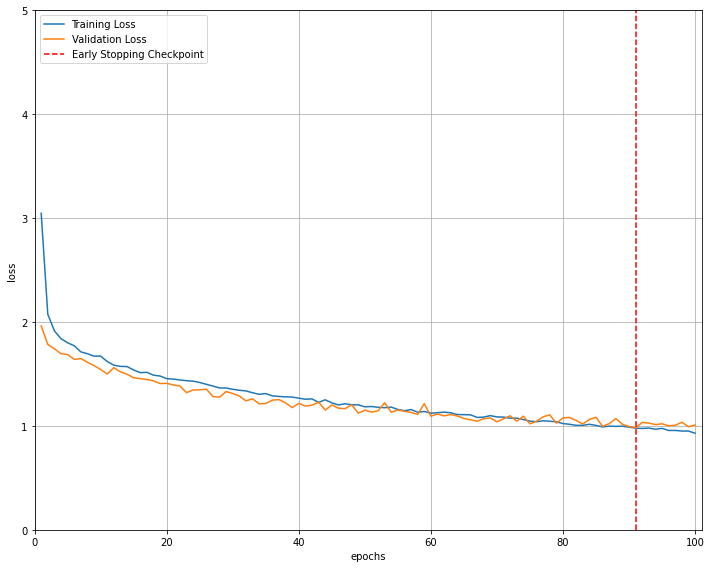

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = val_loss.index(min(val_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

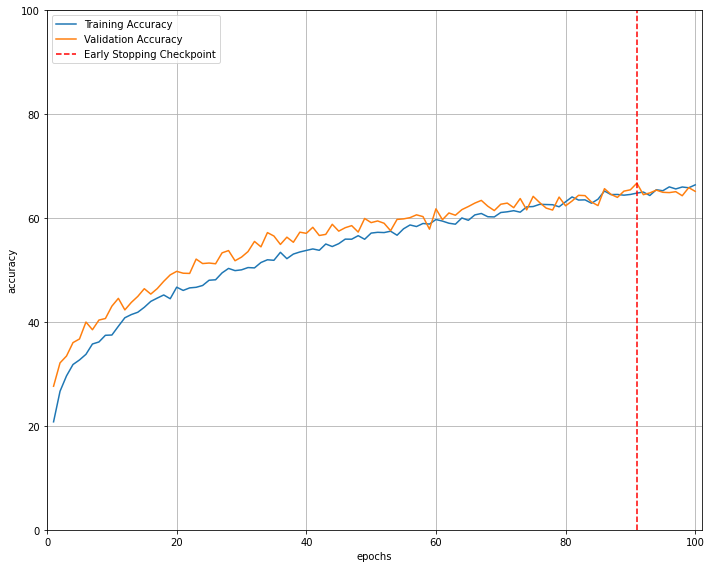

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, label='Training Accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label='Validation Accuracy')

# validation Accuracy의 최대값 지점을 찾기
maxposs = val_accuracy.index(max(val_accuracy))+1
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 100) # 일정한 scale
plt.xlim(0, len(train_accuracy)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('accuracy_plot.png', bbox_inches = 'tight')

In [ ]:
test(model, test_loader, criterion)

Epoch: 1. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.03it/s]


Test Loss: 1.0086, Accuracy: 65.16%


(1.0085896829605103, 65.16)